In [1]:
# example from 
# https://lmfit.github.io/lmfit-py/examples/example_emcee_Model_interface.html

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


matplotlib.rcParams.update({'font.size': 16})

In [2]:
import corner
import lmfit

In [3]:
def double_exp(x, a1, t1, a2, t2):
    return a1*np.exp(-x/t1) + a2*np.exp(-(x-0.1) / t2)


model = lmfit.Model(double_exp)

In [4]:
truths = (3.0, 2.0, -5.0, 10.0)
x = np.linspace(1, 10, 250)
np.random.seed(0)
y = double_exp(x, *truths)+0.1*np.random.randn(x.size)

In [5]:
p = model.make_params(a1=4, t1=3, a2=4, t2=3)


[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 609
    # data points      = 250
    # variables        = 4
    chi-square         = 2.33333982
    reduced chi-square = 0.00948512
    Akaike info crit   = -1160.54007
    Bayesian info crit = -1146.45423
[[Variables]]
    a1:  2.98623689 +/- 0.15010519 (5.03%) (init = 4)
    t1:  1.30993186 +/- 0.13449652 (10.27%) (init = 3)
    a2: -4.33525597 +/- 0.11765819 (2.71%) (init = 4)
    t2:  11.8099125 +/- 0.47172590 (3.99%) (init = 3)
[[Correlations]] (unreported correlations are < 0.100)
    C(a2, t2) =  0.988
    C(t1, a2) = -0.928
    C(t1, t2) = -0.885
    C(a1, t1) = -0.609
    C(a1, a2) =  0.297
    C(a1, t2) =  0.232


/Users/spx8sk/anaconda3/envs/wispy-dev/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/Users/spx8sk/anaconda3/envs/wispy-dev/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in multiply
  
/Users/spx8sk/anaconda3/envs/wispy-dev/lib/python3.7/site-packages/lmfit/minimizer.py:176: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()


(<Figure size 432x432 with 2 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

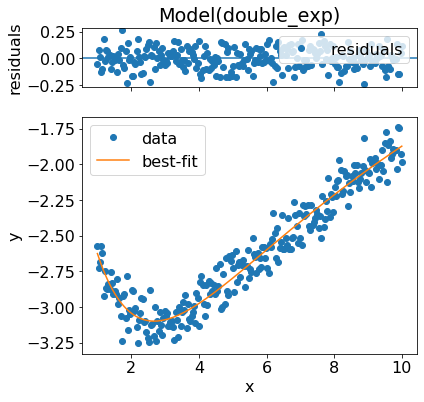

In [6]:
result = model.fit(data=y, params=p, x=x, method='Nelder', nan_policy='omit')

lmfit.report_fit(result)
result.plot()

In [7]:
emcee_kws = dict(steps=1000, burn=300, thin=20, is_weighted=False,
                 progress=True, workers=1, nwalkers=100)
emcee_params = result.params.copy()
emcee_params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2.0))

In [8]:
result_emcee = model.fit(data=y, x=x, params=emcee_params, method='emcee',
                         nan_policy='omit', fit_kws=emcee_kws)

100%|██████████| 1000/1000 [00:08<00:00, 112.72it/s]


In [9]:
lmfit.report_fit(result_emcee)

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 100000
    # data points      = 250
    # variables        = 5
    chi-square         = 245.416732
    reduced chi-square = 1.00170095
    Akaike info crit   = 5.37419896
    Bayesian info crit = 22.9815035
[[Variables]]
    a1:         2.99637789 +/- 0.14769719 (4.93%) (init = 2.986237)
    t1:         1.31956208 +/- 0.13964329 (10.58%) (init = 1.309932)
    a2:        -4.34141084 +/- 0.12287075 (2.83%) (init = -4.335256)
    t2:         11.8038164 +/- 0.48675863 (4.12%) (init = 11.80991)
    __lnsigma: -2.32745163 +/- 0.04471058 (1.92%) (init = -2.302585)
[[Correlations]] (unreported correlations are < 0.100)
    C(a2, t2) =  0.982
    C(t1, a2) = -0.932
    C(t1, t2) = -0.887
    C(a1, t1) = -0.568
    C(a1, a2) =  0.269
    C(a1, t2) =  0.224


In [10]:
ax = plt.plot(x, model.eval(params=result.params, x=x), label='Nelder', zorder=100)
result_emcee.plot_fit(ax=ax, data_kws=dict(color='gray', markersize=2))
plt.show()

In [11]:
plt.plot(result_emcee.sampler.acceptance_fraction)
plt.xlabel('walker')
plt.ylabel('acceptance fraction')
plt.show()

In [12]:
if hasattr(result_emcee, "acor"):
    print("Autocorrelation time for the parameters:")
    print("----------------------------------------")
    for i, p in enumerate(result.params):
        print(p, result.acor[i])

In [13]:
emcee_corner = corner.corner(result_emcee.flatchain, labels=result_emcee.var_names,
                             truths=list(result_emcee.params.valuesdict().values()))

In [14]:
print("\nmedian of posterior probability distribution")
print('--------------------------------------------')
lmfit.report_fit(result_emcee.params)

# find the maximum likelihood solution
highest_prob = np.argmax(result_emcee.lnprob)
hp_loc = np.unravel_index(highest_prob, result_emcee.lnprob.shape)
mle_soln = result_emcee.chain[hp_loc]
print("\nMaximum likelihood Estimation")
print('-----------------------------')
for ix, param in enumerate(emcee_params):
    print(param + ': ' + str(mle_soln[ix]))

quantiles = np.percentile(result_emcee.flatchain['t1'], [2.28, 15.9, 50, 84.2, 97.7])
print("\n\n1 sigma spread", 0.5 * (quantiles[3] - quantiles[1]))
print("2 sigma spread", 0.5 * (quantiles[4] - quantiles[0]))


median of posterior probability distribution
--------------------------------------------
[[Variables]]
    a1:         2.99637789 +/- 0.14769719 (4.93%) (init = 2.986237)
    t1:         1.31956208 +/- 0.13964329 (10.58%) (init = 1.309932)
    a2:        -4.34141084 +/- 0.12287075 (2.83%) (init = -4.335256)
    t2:         11.8038164 +/- 0.48675863 (4.12%) (init = 11.80991)
    __lnsigma: -2.32745163 +/- 0.04471058 (1.92%) (init = -2.302585)
[[Correlations]] (unreported correlations are < 0.100)
    C(a2, t2) =  0.982
    C(t1, a2) = -0.932
    C(t1, t2) = -0.887
    C(a1, t1) = -0.568
    C(a1, a2) =  0.269
    C(a1, t2) =  0.224

Maximum likelihood Estimation
-----------------------------
a1: 2.9516079567371394
t1: 1.320921622273492
a2: -4.333103563716343
t2: 11.84652506057183
__lnsigma: -2.3328583631734823


1 sigma spread 0.1400890324368197
2 sigma spread 0.27734213482239367


# try gauss2 fitting

In [15]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


matplotlib.rcParams.update({'font.size': 16})

In [16]:
import corner
import lmfit

In [17]:
def exp_model(x, A, tau):
    return A*np.exp(-x/tau)

def gaussian(x, amp, cen, wid):
    return amp * np.exp(-(x-cen)**2 / wid)

# First, we define our "signal model", in this case a simple linear function
def ansatz(x, g1_amp,g1_cen,g1_wid, g2_amp,g2_cen,g2_wid, e_A, e_tau):

    g1 = gaussian(x, g1_amp,g1_cen,g1_wid)
    g2 = gaussian(x, g2_amp,g2_cen,g2_wid)
    ex = exp_model(x, e_A, e_tau)

    return g1 + g2 + ex

model = lmfit.Model(ansatz)

In [18]:
model.param_names

['g1_amp', 'g1_cen', 'g1_wid', 'g2_amp', 'g2_cen', 'g2_wid', 'e_A', 'e_tau']

In [19]:
model.independent_vars

['x']

In [20]:
y, x = np.loadtxt('../Gauss2.dat', unpack=True)

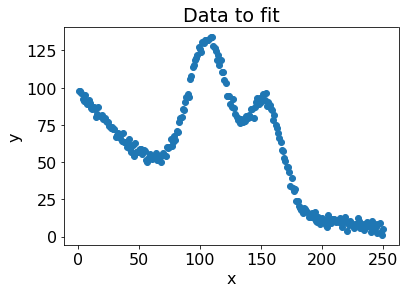

In [21]:
plt.figure()
plt.scatter(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Data to fit")
plt.show()
plt.close()

In [22]:
params = {'g1_amp':80, 'g1_cen':80, 'g1_wid':80, 'g2_amp':80, 'g2_cen':80, 'g2_wid':80, 'e_A':80, 'e_tau':80}
p = model.make_params(**params)

In [23]:
p

Parameters([('g1_amp', <Parameter 'g1_amp', 80, bounds=[-inf:inf]>),
            ('g1_cen', <Parameter 'g1_cen', 80, bounds=[-inf:inf]>),
            ('g1_wid', <Parameter 'g1_wid', 80, bounds=[-inf:inf]>),
            ('g2_amp', <Parameter 'g2_amp', 80, bounds=[-inf:inf]>),
            ('g2_cen', <Parameter 'g2_cen', 80, bounds=[-inf:inf]>),
            ('g2_wid', <Parameter 'g2_wid', 80, bounds=[-inf:inf]>),
            ('e_A', <Parameter 'e_A', 80, bounds=[-inf:inf]>),
            ('e_tau', <Parameter 'e_tau', 80, bounds=[-inf:inf]>)])

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1823
    # data points      = 250
    # variables        = 8
    chi-square         = 1247.52821
    reduced chi-square = 5.15507524
    Akaike info crit   = 417.864631
    Bayesian info crit = 446.036318
[[Variables]]
    g1_amp:  72.0455899 +/- 0.61692750 (0.86%) (init = 80)
    g1_cen:  153.270103 +/- 0.19597092 (0.13%) (init = 80)
    g1_wid:  381.263663 +/- 10.2939354 (2.70%) (init = 80)
    g2_amp:  101.880222 +/- 0.59230970 (0.58%) (init = 80)
    g2_cen:  107.030954 +/- 0.15044186 (0.14%) (init = 80)
    g2_wid:  555.949623 +/- 10.7939331 (1.94%) (init = 80)
    e_A:     99.0183271 +/- 0.53718486 (0.54%) (init = 80)
    e_tau:   90.9257843 +/- 1.10206671 (1.21%) (init = 80)
[[Correlations]] (unreported correlations are < 0.100)
    C(e_A, e_tau)     = -0.694
    C(g1_cen, g2_wid) =  0.688
    C(g1_wid, g2_cen) = -0.654
    C(g1_cen, g2_cen) =  0.625
    C(g2_cen, g2_wid) =  0.512
    C(g1_cen, g1_w

(<Figure size 432x432 with 2 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

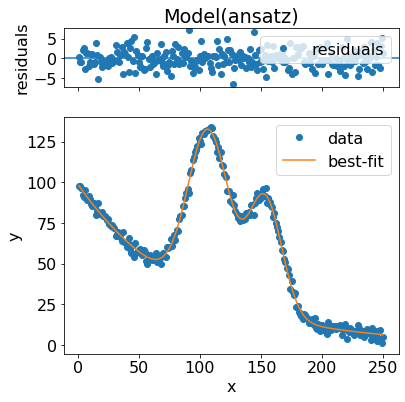

In [24]:
result = model.fit(data=y, params=p, x=x, method='Nelder', nan_policy='omit')

lmfit.report_fit(result)
result.plot()

In [36]:
emcee_kws = dict(steps=5000, burn=300, thin=40, is_weighted=False,
                 progress=True, nwalkers=100)

emcee_params = result.params.copy()
emcee_params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(4.0))

In [38]:
result_emcee = model.fit(data=y, x=x, params=emcee_params, method='emcee',
                         nan_policy='omit', fit_kws=emcee_kws)

100%|██████████| 5000/5000 [00:52<00:00, 94.40it/s] 


In [39]:
lmfit.report_fit(result_emcee)

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 500000
    # data points      = 250
    # variables        = 9
    chi-square         = 240.423495
    reduced chi-square = 0.99760786
    Akaike info crit   = 8.23525301
    Bayesian info crit = 39.9284013
[[Variables]]
    g1_amp:     72.0481514 +/- 0.63017013 (0.87%) (init = 72.04559)
    g1_cen:     153.262285 +/- 0.20491914 (0.13%) (init = 153.2701)
    g1_wid:     381.594109 +/- 10.9173923 (2.86%) (init = 381.2637)
    g2_amp:     101.883159 +/- 0.60978295 (0.60%) (init = 101.8802)
    g2_cen:     107.024207 +/- 0.15846499 (0.15%) (init = 107.031)
    g2_wid:     555.602244 +/- 11.2639691 (2.03%) (init = 555.9496)
    e_A:        99.0016096 +/- 0.55689581 (0.56%) (init = 99.01833)
    e_tau:      90.9296660 +/- 1.15209209 (1.27%) (init = 90.92578)
    __lnsigma:  0.82328043 +/- 0.04706968 (5.72%) (init = -2.302585)
[[Correlations]] (unreported correlations are < 0.100)
    C(g1_wid, g2_cen)    = -0.789
   

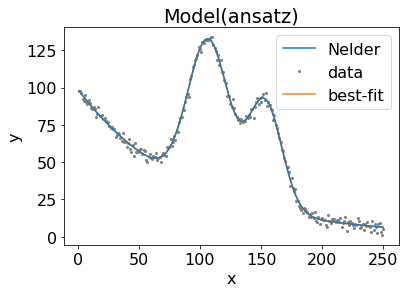

In [40]:
ax = plt.plot(x, model.eval(params=result.params, x=x), label='Nelder', zorder=100)
result_emcee.plot_fit(ax=ax, data_kws=dict(color='gray', markersize=2))
plt.show()

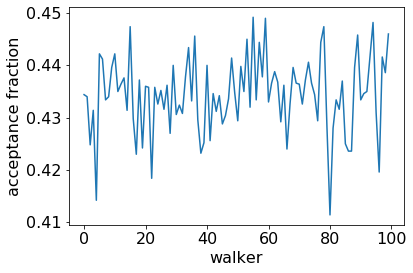

In [41]:
plt.plot(result_emcee.sampler.acceptance_fraction)
plt.xlabel('walker')
plt.ylabel('acceptance fraction')
plt.show()

In [42]:
if hasattr(result_emcee, "acor"):
    print("Autocorrelation time for the parameters:")
    print("----------------------------------------")
    for i, p in enumerate(result.params):
        print(p, result.acor[i])

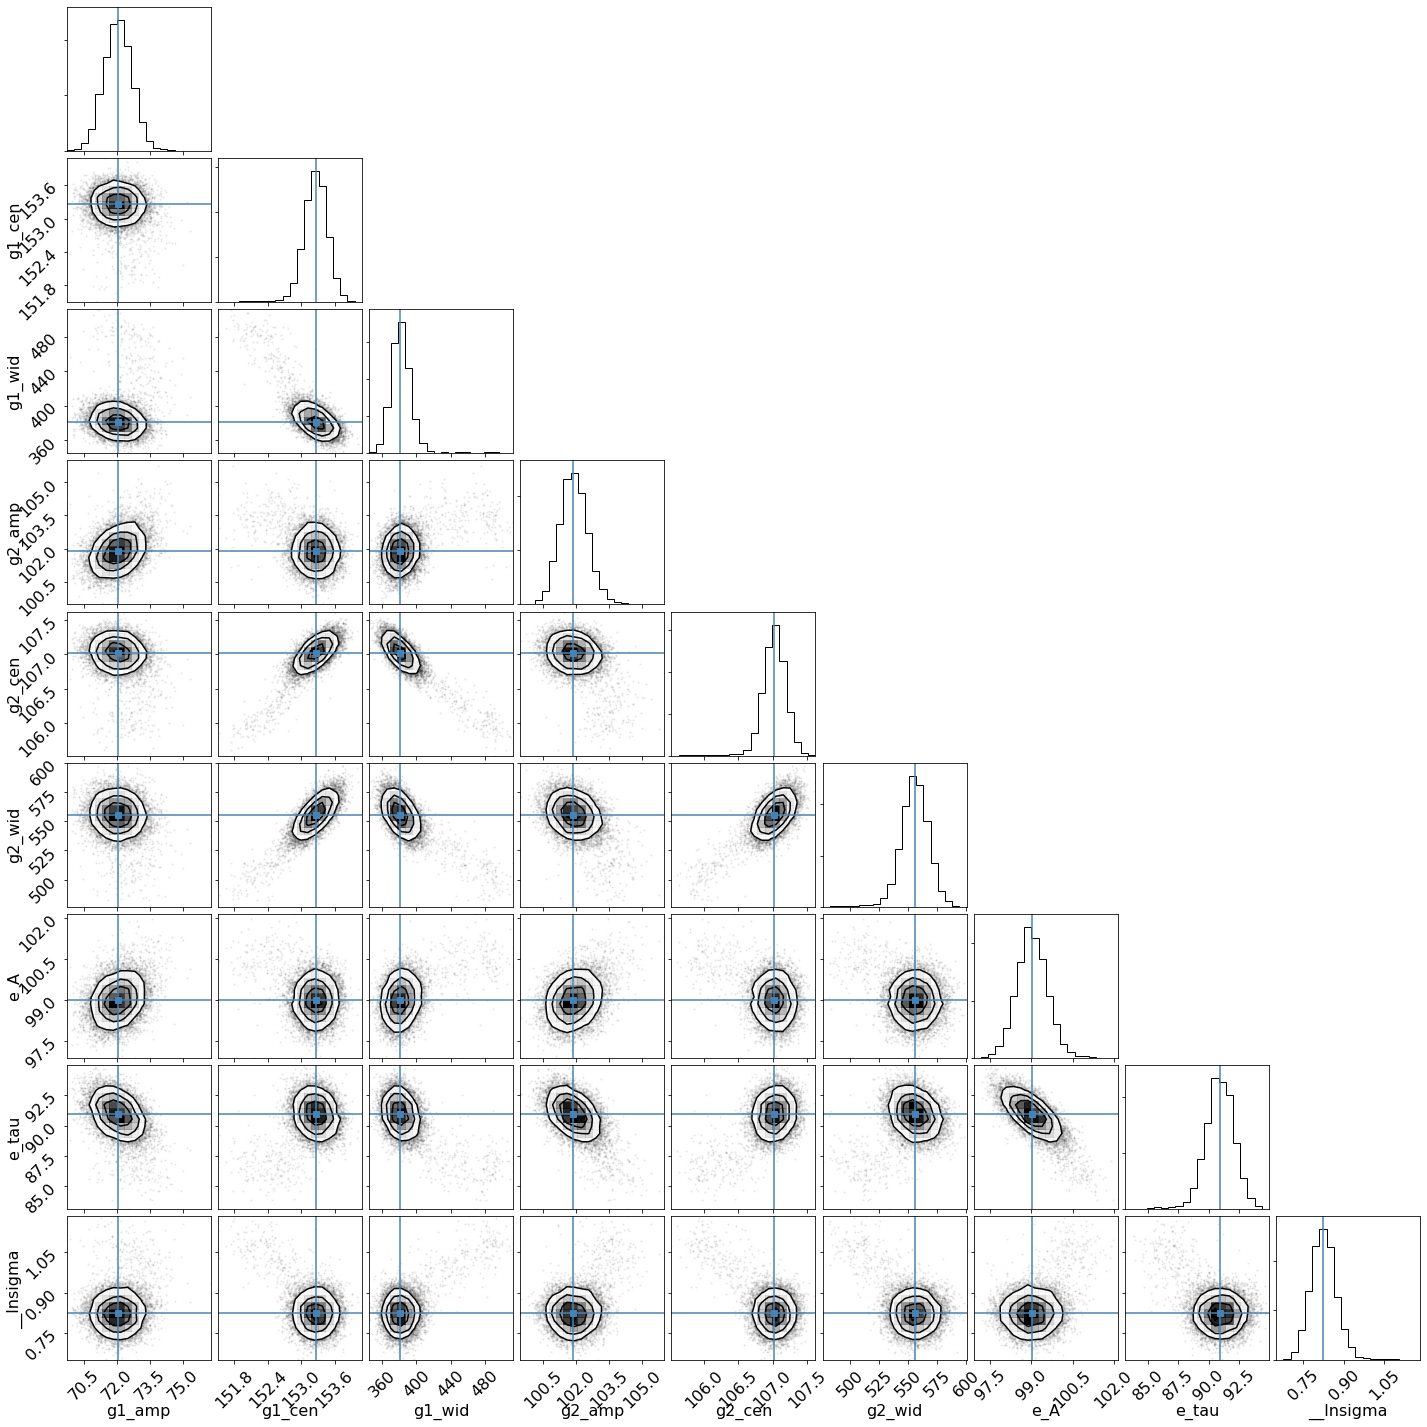

In [43]:
emcee_corner = corner.corner(result_emcee.flatchain, labels=result_emcee.var_names,
                             truths=list(result_emcee.params.valuesdict().values()))

In [44]:
print("\nmedian of posterior probability distribution")
print('--------------------------------------------')
lmfit.report_fit(result_emcee.params)

# find the maximum likelihood solution
highest_prob = np.argmax(result_emcee.lnprob)
hp_loc = np.unravel_index(highest_prob, result_emcee.lnprob.shape)
mle_soln = result_emcee.chain[hp_loc]
print("\nMaximum likelihood Estimation")
print('-----------------------------')
for ix, param in enumerate(emcee_params):
    print(param + ': ' + str(mle_soln[ix]))

quantiles = np.percentile(result_emcee.flatchain['g1_amp'], [2.28, 15.9, 50, 84.2, 97.7])
print("\n\n1 sigma spread", 0.5 * (quantiles[3] - quantiles[1]))
print("2 sigma spread", 0.5 * (quantiles[4] - quantiles[0]))


median of posterior probability distribution
--------------------------------------------
[[Variables]]
    g1_amp:     72.0481514 +/- 0.63017013 (0.87%) (init = 72.04559)
    g1_cen:     153.262285 +/- 0.20491914 (0.13%) (init = 153.2701)
    g1_wid:     381.594109 +/- 10.9173923 (2.86%) (init = 381.2637)
    g2_amp:     101.883159 +/- 0.60978295 (0.60%) (init = 101.8802)
    g2_cen:     107.024207 +/- 0.15846499 (0.15%) (init = 107.031)
    g2_wid:     555.602244 +/- 11.2639691 (2.03%) (init = 555.9496)
    e_A:        99.0016096 +/- 0.55689581 (0.56%) (init = 99.01833)
    e_tau:      90.9296660 +/- 1.15209209 (1.27%) (init = 90.92578)
    __lnsigma:  0.82328043 +/- 0.04706968 (5.72%) (init = -2.302585)
[[Correlations]] (unreported correlations are < 0.100)
    C(g1_wid, g2_cen)    = -0.789
    C(g1_cen, g2_wid)    =  0.751
    C(g1_cen, g2_cen)    =  0.729
    C(e_A, e_tau)        = -0.723
    C(g1_cen, g1_wid)    = -0.652
    C(g2_cen, g2_wid)    =  0.631
    C(g1_wid, g2_wid)   